# Alzheimer Disease and Healthy Aging Data in US的数据分析与处理

## 1. 摘要分析和可视化

### 摘要分析
首先编写分析数据摘要的函数，如下。其中`calc_5num_abstract()`函数用来计算数值属性的五数概括，`analyze_abstract_github()`用来进行数据摘要的提取，之后`print_abstract()`函数用来在控制台打印分析结果，`save_abstract()`用于将分析结果保存为.csv格式。

In [1]:
import pandas as pd
import numpy as np
import os


def calc_5num_abstract(arr: np.ndarray):
    n_max = np.nanmax(arr)
    n_min = np.nanmin(arr)
    q1 = np.percentile(arr, 25)
    median = np.nanmedian(arr)
    q3 = np.percentile(arr, 75)
    return n_min, q1, median, q3, n_max


def analyze_abstract_github(df: pd.DataFrame) -> dict:
    print("analyzing data")
    analyze_results = {}
    for col in df.columns:
        if df[col].dtype == object:
            count = df[col].value_counts()
            df_meta = {col: count.index, "count": count.values}
            analyze_results[col] = pd.DataFrame(df_meta)
        else:
            values = df[col].values
            mask = np.isnan(values)
            if len(values[np.logical_not(mask)]) == 0:
                print(f"The column {col} has no data.")
                continue
            n_min, q1, median, q3, n_max = calc_5num_abstract(values[np.logical_not(mask)])
            null_calc = df[col].isnull().sum()
            res = pd.DataFrame(
                {"min": [n_min], "Q1": [q1], "median": [median], "Q3": [q3], "max": [n_max], "blanks": [null_calc]})
            analyze_results[col] = res
    return analyze_results


def print_abstract(result):
    for k, v in result.items():
        print(k, v.to_string(index=False, max_rows=20), sep="\n")
        print()


def save_abstract(path, result):
    os.makedirs(path, exist_ok=True)
    for k, v in result.items():
        v.to_csv(os.path.join(path, f"{k}.csv"), index=False)

下面的代码用来实现摘要分析。

In [2]:
print("Analyzing Alzheimer Disease and Healthy Aging Data In US.csv")
df_alzheimer_data = pd.read_csv("data/alzheimer/Alzheimer Disease and Healthy Aging Data In US.csv")
res = analyze_abstract_github(df_alzheimer_data)
result_dir = "result/alzheimer/"
print_abstract(res)
save_abstract(result_dir, res)

Analyzing Alzheimer Disease and Healthy Aging Data In US.csv


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22900\265366865.py:2: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_alzheimer_data = pd.read_csv("data/alzheimer/Alzheimer Disease and Healthy Aging Data In US.csv")


analyzing data
The column Sample_Size has no data.
YearStart
 min     Q1  median     Q3  max  blanks
2015 2016.0  2017.0 2019.0 2020       0

YearEnd
 min     Q1  median     Q3  max  blanks
2015 2016.0  2018.0 2019.0 2020       0

LocationAbbr
LocationAbbr  count
          US   4644
        WEST   4638
         NRE   4614
         MDW   4611
          OR   4565
          NY   4557
         SOU   4542
          UT   4222
          OH   3955
          GA   3951
         ...    ...
          NC   3349
          WA   3348
          MT   3348
          DE   3346
          NH   3284
          VT   3278
          MA   3174
          PR   2797
          GU   2703
          VI    503

LocationDesc
                   LocationDesc  count
United States, DC & Territories   4644
                           West   4638
                      Northeast   4614
                        Midwest   4611
                         Oregon   4565
                       New York   4557
                          Sou

运行结束后，可以在`./result/alzheimer`目录中找到摘要分析结果。对于标称数据，表格包含两列：可能取值及其频数；对于数值数据，表格中包含6列，分别是`min`（最小值）、`Q1`（第一四分位数）、`median`（中位数）、`Q3`（第三四分位数）、`max`（最大值）、`blanks`（缺失数据个数。

### 数据可视化

下面对Alzheimer Disease and Healthy Aging Data In US.csv的数据进行可视化，包含直方图、盒图。下面分别对两种图编写可视化函数。

In [3]:
def draw_histogram(df: pd.DataFrame):
    for col in df.columns:
        if df[col].dtype != object and len(df[~df[col].isnull()]) > 0:
            df.hist(column=col, bins=100)


def draw_boxgram(df: pd.DataFrame, columns=None):
    if columns is None:
        df.boxplot()
    else:
        df.boxplot(column=columns)

直方图

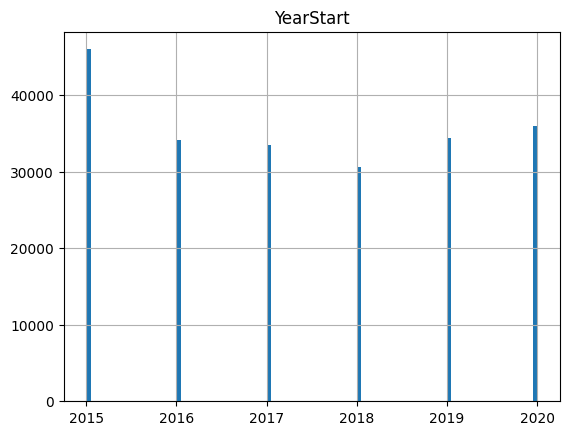

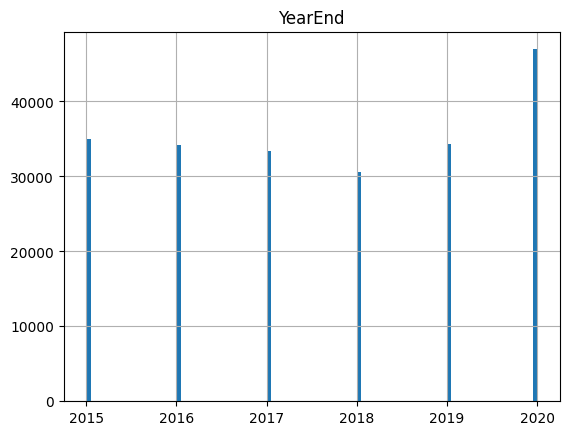

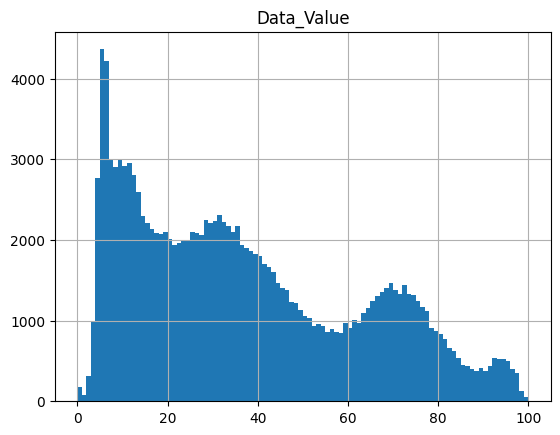

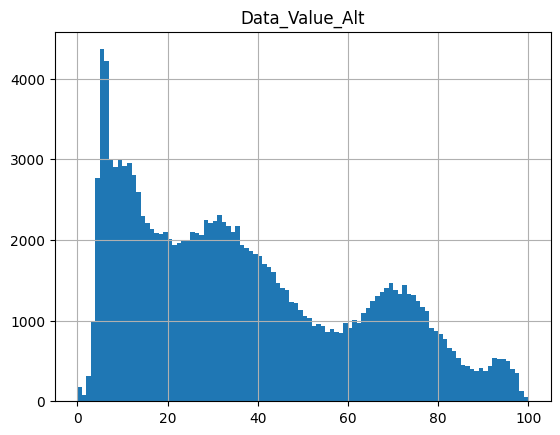

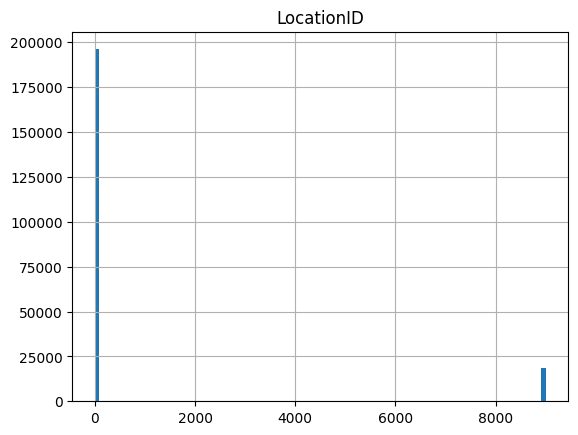

In [4]:
draw_histogram(df_alzheimer_data)

盒图

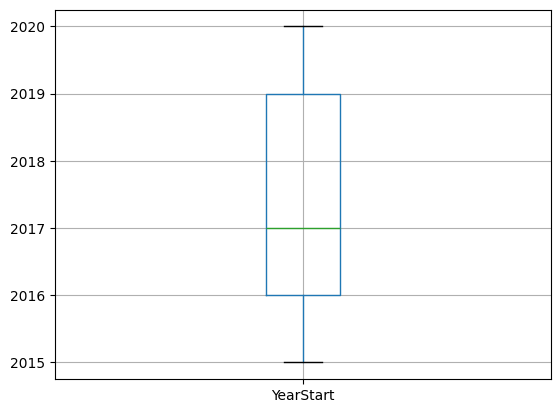

In [5]:
draw_boxgram(df_alzheimer_data, columns="YearStart")

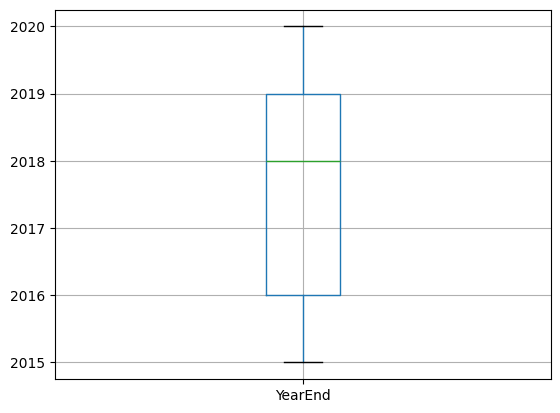

In [6]:
draw_boxgram(df_alzheimer_data, columns="YearEnd")

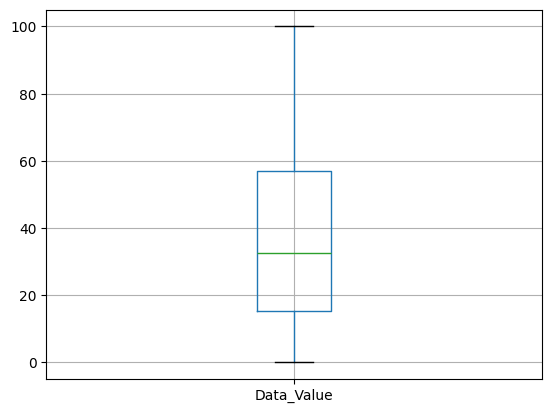

In [7]:
draw_boxgram(df_alzheimer_data, columns="Data_Value")

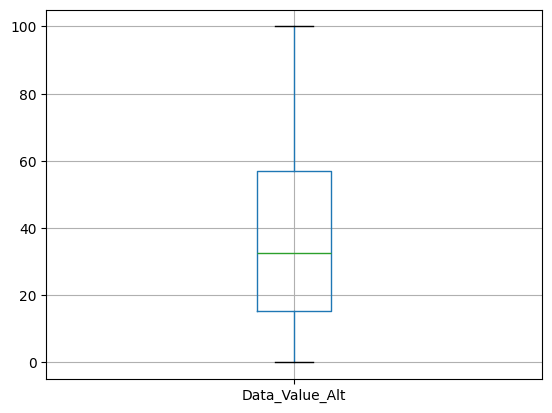

In [8]:
draw_boxgram(df_alzheimer_data, columns="Data_Value_Alt")

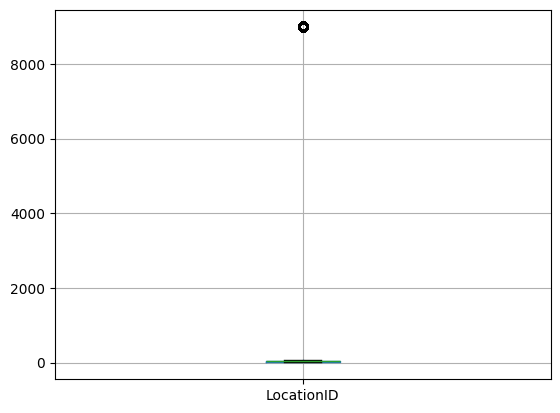

In [9]:
draw_boxgram(df_alzheimer_data, columns="LocationID")

## 2. 数据缺失处理

先寻找缺失的列

In [10]:
for col in df_alzheimer_data.columns:
    if df_alzheimer_data[col].isnull().sum() > 0 and df_alzheimer_data[col].dtype != object:
        print(col)

Data_Value
Data_Value_Alt
Sample_Size


首先是缺失数据剔除。由于Sample_Size列均为null，因此剔除该列：

In [11]:
print(df_alzheimer_data.shape)

(214462, 29)


In [12]:
df = df_alzheimer_data.copy()
del df["Sample_Size"]
print(df.shape)

(214462, 28)


删除了一列数据。

第二个是用最高频率值填补缺失值

In [13]:
null_lines = df_alzheimer_data["Data_Value"].isnull()
print(df_alzheimer_data[null_lines]["Data_Value"])

32       NaN
33       NaN
42       NaN
47       NaN
48       NaN
          ..
214456   NaN
214457   NaN
214458   NaN
214459   NaN
214461   NaN
Name: Data_Value, Length: 69833, dtype: float64


In [14]:
freq_max = df_alzheimer_data["Data_Value"].value_counts().index[0]
print(freq_max)

6.0


In [15]:
df = df_alzheimer_data["Data_Value"].fillna(freq_max)
print(df[null_lines])

32        6.0
33        6.0
42        6.0
47        6.0
48        6.0
         ... 
214456    6.0
214457    6.0
214458    6.0
214459    6.0
214461    6.0
Name: Data_Value, Length: 69833, dtype: float64


可以看到缺失值均被填充为了2.0（最大频率值）。

下面使用平均数来填充缺失值。

In [16]:
mean = df_alzheimer_data["Data_Value"].mean()
print(mean)

37.34195562439067


In [17]:
df = df_alzheimer_data["Data_Value"].fillna(mean)
print(df[null_lines])

32        37.341956
33        37.341956
42        37.341956
47        37.341956
48        37.341956
            ...    
214456    37.341956
214457    37.341956
214458    37.341956
214459    37.341956
214461    37.341956
Name: Data_Value, Length: 69833, dtype: float64


空值均被填充为了平均数

下面使用前后值来填充

In [18]:
df = df_alzheimer_data["Data_Value"].fillna(method="pad")
print(df[null_lines])

32        68.5
33        68.5
42         7.6
47        41.5
48        41.5
          ... 
214456    18.7
214457    18.7
214458    18.7
214459    18.7
214461    10.6
Name: Data_Value, Length: 69833, dtype: float64
